In [6]:
from langgraph.graph import StateGraph, START,END
from langchain_core.messages import BaseMessage,HumanMessage,ToolMessage,SystemMessage
from langchain_core.tools import tool
from langgraph.graph import add_messages
from langgraph.prebuilt import ToolNode
from typing import TypedDict,Annotated,Sequence,List

In [7]:
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
llm = ChatGroq(model="Gemma2-9b-It")

## Orchestrator, Synthesizer workflow

### So its like a manager, which first creates a draft report which has the structure ready and then assigns/ creates one worker per section. Workers are like llm calls being made for each sections, and after this, a synthesizer then combines all the sections, made by workers in the final draft. and we have a final solution of the problem

In [8]:
from pydantic import BaseModel,Field

class Section(BaseModel):
    name:str = Field(description="Name for this section")
    description:str= Field(description="Description for the section")

class Sections(BaseModel):
    sections: List[Section]=Field(description="Worker's sections")

## Augmenting LLm to return a particular type of output
orchester_llm = llm.with_structured_output(Sections)

### Dynamic workers creation - Send API Lets you do it, (It creates workers and all have a shared state so that orchester has acces to it)

In [9]:
from langgraph.constants import Send
from typing import TypedDict
import operator

class AgentState(TypedDict):
    topic:str
    sections: list[Section]
    completed_sections: Annotated[list,operator.add]
    final_report:str

In [10]:
## Dynamic worker State

class WorkerState(TypedDict):
    Section:Section
    completed_sections: Annotated[list,operator.add] 

In [27]:
def orchestrator(state:AgentState):
    ### manager, generator initial report structure
    #### then create workers and assign them sections

    report_initial = orchester_llm.invoke(
        [
            SystemMessage(content="Generate a technical and report plan for the topic"),
            HumanMessage(content=f"Here is the topic : {state['topic']}")
        ]
    )
    ### report making done, and the output has to be list of sections, because we have Augmented LLM to give a particular type of output!!
    return {"sections":report_initial.sections}

In [54]:
def llm_call(state:WorkerState):
    """Worker write a report for each section"""
    
    report_section = llm.invoke(
        [
            SystemMessage(content= f"Write a section of the report provided the name and the description. Remeber to be mathematical and technical" ),
            HumanMessage(content=f"Here is the section name : {state['Section'].name}and description : {state['Section'].description} ")
        ]
    )

    return {"completed_sections":[report_section.content]}

In [63]:
####  Send api to dynamically call llm depending on the number of sections created in orchester nodel

def assign_calls(state:AgentState):

    return [Send("Dynamic_Workers", {"Section":s}) for s in state["sections"]]

In [57]:
def synthesizer(state:AgentState):

    completed_section = state['completed_sections']

    all_sections = "\n\n---\n\n".join(completed_section)

    return {"final_report":all_sections}

In [64]:
graph = StateGraph(AgentState)

graph.add_node("Orchester/Manager",orchestrator)
graph.add_node("Dynamic_Workers",llm_call)
graph.add_node("synthesizer",synthesizer)

graph.add_edge(START,"Orchester/Manager")
graph.add_conditional_edges(
    "Orchester/Manager",
    assign_calls,
    {"Dynamic_Workers":"Dynamic_Workers"}
)
graph.add_edge("Dynamic_Workers","synthesizer")
graph.add_edge("synthesizer",END)

build = graph.compile()

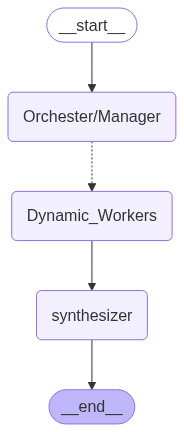

In [65]:
from IPython.display import Image,display,Markdown
display(Image(build.get_graph().draw_mermaid_png()))

## Blog Generation using Orchester/Synthesizer Workflow

In [66]:
resp = build.invoke({"topic":"Report on Retrieval Augmented Generation"})

Markdown(resp["final_report"])

## Introduction to Retrieval Augmented Generation (RAG)

Retrieval Augmented Generation (RAG) represents a paradigm shift in natural language generation (NLG) by seamlessly integrating external knowledge sources into the generative process. Traditional NLG models rely solely on their internal training data, often leading to limitations in factual accuracy, factual consistency, and the ability to access specialized domain knowledge. RAG addresses these limitations by incorporating a retrieval component that retrieves relevant information from a vast external knowledge base (KB).

**The RAG framework comprises two key components:**

1. **Retrieval Module:** This component acts as a query processor, taking a user's prompt or query as input and retrieving the most relevant passages from the KB.  Various techniques can be employed for retrieval, including:
    * **Dense Passage Retrieval (DPR):** Utilizes learned embeddings of both queries and passages to compute semantic similarity. 
    * **BM25:**  A classic ranking algorithm based on term frequency and inverse document frequency.
    * **Transformer-based Retrieval:** Employs transformer models, like BERT or RoBERTa, to capture contextual information and improve passage relevance. 

2. **Generation Module:**  This component leverages the retrieved information to generate a comprehensive and coherent response.  

    * **Prompt Engineering:** The retrieved passages are carefully incorporated into the prompt for the generation module, providing context and guiding the generation process.

    * **In-Context Learning:** The generation model learns to use the retrieved information within the given context, effectively incorporating external knowledge into its generation capabilities.

**Mathematical Representation:**

RAG can be represented mathematically as a function:

**G(Q, KB) = f(R(Q, KB), P)**

Where:

* **G(Q, KB)** represents the generated response given a query **Q** and a knowledge base **KB**.
* **R(Q, KB)** is the set of retrieved passages from **KB** based on **Q**.
* **P** is the generation prompt, which incorporates **R(Q, KB)**.
* **f()** is the generation function, which utilizes **P** to produce the final response.

**Benefits of RAG:**

* Enhanced Factual Accuracy: By grounding generation in external knowledge sources, RAG significantly improves the accuracy and reliability of generated responses.
* Domain Expertise: RAG allows access to specialized domain knowledge, enabling the generation of more informed and insightful responses in specific fields.
* Contextual Coherence: The retrieval and incorporation of relevant passages enhance the contextual coherence and relevance of generated text.
* Scalability & Adaptability: RAG systems can be readily adapted to new domains and knowledge bases by updating the underlying KB. 


This introduction provides a foundational understanding of RAG, highlighting its key components, mathematical representation, and potential benefits. 


---

## RAG Models: Architectures and Types

Retrieval-Augmented Generation (RAG) models combine the strengths of large language models (LLMs) with the factual grounding provided by external knowledge sources. This section explores the diverse architectures and types of RAG models, highlighting their key characteristics and functionalities.

**1. Architecture Overview:**

At their core, RAG models consist of two primary components:

* **Information Retriever:** This component acts as the knowledge seeker, retrieving relevant passages from a knowledge base (KB) based on a given user query. Common information retrieval techniques employed include:
    * **BM25:** A ranking function that considers both term frequency and inverse document frequency in the KB to score passage relevance.
    * **Dense Passage Retrieval (DPR):** Utilizes embedding techniques to represent both queries and passages as dense vectors, allowing for similarity-based retrieval.
* **Generative Model:** This component processes the retrieved passages and generates a response based on the user's query. It leverages the power of LLMs to understand context, synthesize information, and generate coherent and grammatically correct text. Popular generative models include:
    * **Transformer-based LLMs:** Architectures like BERT, GPT, and T5 excel at understanding and generating human-like text, making them suitable for RAG.

**2. Types of RAG Models:**

Several variations of RAG models exist, each tailored to specific use cases and knowledge base structures.

* **Query-Based RAG:** The most common type, where the retriever retrieves passages directly related to the user's query. 
* **Context-Aware RAG:** Involves incorporating contextual information from previous interactions or dialogue history to refine both retrieval and generation processes.
* **Chain-of-Thought RAG:**  Encourages the model to explicitly reason through the information retrieved, breaking down complex tasks into a series of steps.
* **Multi-Modal RAG:** Extends RAG to incorporate other modalities like images, audio, or video, enabling richer and more comprehensive responses.

**3. Key Considerations:**

Choosing the appropriate RAG model architecture and type depends on factors such as:

* **Knowledge Base Structure:** The format and organization of the KB influence the retrieval strategy.
* **Task Complexity:**  Complex tasks requiring reasoning and multi-step solutions benefit from more sophisticated architectures like Chain-of-Thought RAG.
* **Resource Availability:** Training and deploying complex RAG models can be computationally expensive.

**4. Future Directions:**

Research in RAG is rapidly evolving, focusing on:

* **Improved Retrieval Techniques:**  Exploring novel methods for efficient and accurate passage retrieval, particularly for large and complex KBs.
* **Enhanced Generation Capabilities:**  Developing more sophisticated generative models capable of handling diverse tasks and generating nuanced and creative responses.
* **Explainability and Trustworthiness:**  Making RAG models more transparent and interpretable to build trust and understand their decision-making processes.



This section provides a foundational understanding of RAG models and their diverse implementations. As the field continues to advance, we can expect even more powerful and versatile RAG systems capable of revolutionizing how we interact with information. 


---

## Applications of RAG

This section delves into the diverse applications of Retrieval-Augmented Generation (RAG) across various domains. RAG's ability to seamlessly integrate external knowledge with generative capabilities unlocks novel solutions and enhances performance in numerous tasks.

**1. Question Answering (QA):**

RAG significantly improves the accuracy and comprehensiveness of question answering systems. By retrieving relevant information from a knowledge base, RAG allows models to provide more precise and contextually rich answers compared to purely generative approaches. This is particularly beneficial in domains with vast amounts of factual information, such as:

* **E-commerce:** Answering customer queries about product specifications, availability, and reviews.
* **Education:** Providing students with detailed answers to questions based on textbooks, research papers, and online learning materials.
* **Healthcare:** Assisting medical professionals in retrieving patient information, drug interactions, and clinical guidelines.

**2. Text Summarization:**

RAG enhances text summarization by enabling models to access and incorporate relevant background information. 

This results in summaries that are more accurate, informative, and contextually aligned with the original text. Applications include:

* **News Aggregation:** Generating concise summaries of multiple news articles on a specific topic.
* **Meeting Minutes:** Creating accurate and comprehensive summaries of meeting discussions.
* **Research Paper Abstracts:** Generating succinct summaries of research papers for easier comprehension.

**3. Dialogue Systems:**

RAG empowers dialogue systems to engage in more natural and meaningful conversations.

By retrieving relevant information from a knowledge base, models can provide more contextually aware and helpful responses. This is crucial for applications like:

* **Customer Service Chatbots:**  Providing accurate and personalized support to customers.
* **Virtual Assistants:** Answering user queries, scheduling appointments, and completing tasks.
* **Educational Chatbots:** Guiding students through learning materials and providing personalized instruction.

**4. Creative Writing:**

RAG can be used to assist in creative writing tasks by providing writers with relevant information, inspiration, and suggestions.

For example, RAG can:

* **Generate story ideas:** By retrieving information from a database of plots, characters, and settings.
* **Suggest character traits:** Based on a description of the character's background and motivations.
* **Provide historical context:** For fictional stories set in the past.

**5. Code Generation:**

RAG can assist in code generation by retrieving relevant code snippets, documentation, and examples.

This can help developers write code more efficiently and accurately.

* **Suggest code snippets:** Based on a natural language description of the desired functionality.
* **Generate documentation:** For existing code based on comments and function signatures.
* **Translate code between programming languages:** By retrieving equivalent code snippets in the target language.



These examples demonstrate the versatility and potential of RAG across diverse domains. As research and development in this field continue, we can expect even more innovative applications of RAG to emerge, further blurring the lines between human intelligence and artificial intelligence. 


---

## Challenges and Future Directions

Recent advancements in Retrieval Augmented Generation (RAG) have demonstrated significant potential for enhancing the capabilities of language models. However, several challenges remain to be addressed before RAG can fully realize its potential and achieve widespread adoption. 

**1. Data Efficiency and Bias:** 

Current RAG models often require massive datasets for training, which can be expensive and time-consuming to acquire. Moreover, biases present in training data can be amplified by the retrieval process, leading to unfair or inaccurate outputs. Future research should focus on developing more data-efficient training methods and exploring techniques to mitigate bias in both the retrieved information and the generated text.

**2. Retrieval Accuracy and Relevance:**

The quality of retrieved information directly impacts the quality of the generated output. Existing retrieval methods often struggle to identify highly relevant documents, especially when dealing with complex or nuanced queries. 

Improvements in retrieval techniques, such as incorporating semantic understanding, contextual awareness, and personalized search strategies, are crucial for enhancing RAG performance.

**3. Explainability and Interpretability:**

The black-box nature of many RAG models makes it difficult to understand how they arrive at their outputs.  Developing techniques to improve the explainability and interpretability of RAG models is essential for building trust and ensuring responsible use. This includes visualizing the retrieval process, identifying influential retrieved documents, and providing insights into the reasoning behind the generated text.

**4. Scalability and Efficiency:**

Scaling RAG systems to handle large-scale real-world applications poses significant computational and infrastructural challenges.  Research on efficient indexing and retrieval algorithms, as well as distributed training and inference techniques, is needed to address these scalability concerns.

**Future Directions:**

* **Hybrid Approaches:** Combining RAG with other AI techniques, such as knowledge graphs and reasoning engines, can lead to more comprehensive and intelligent systems.
* **Multi-Modal RAG:** Extending RAG to incorporate other modalities, such as images, audio, and video, can unlock new possibilities for richer and more interactive applications.
* **Personalization and Customization:**  Developing personalized RAG systems that adapt to individual user needs and preferences will enhance user experience and enable more tailored applications.
* **Ethical Considerations:**  Addressing ethical concerns related to bias, fairness, and accountability in RAG systems is crucial for ensuring responsible development and deployment.



By tackling these challenges and exploring these future directions, the field of RAG can continue to advance and unlock the full potential of language models for a wide range of applications. 
